In [4]:
import pypsa, os
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import pandas as pd

import warnings
from shapely.errors import ShapelyDeprecationWarning

warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)
plt.rc("figure", figsize=(10, 8))
import matplotlib as mpl
to_rgba = mpl.colors.colorConverter.to_rgba

In [7]:
from vresutils import Dict
from snakemake.rules import expand
import yaml
snakemake = Dict()
snakemake.wildcards = Dict(#cost=#'IRP2016-Apr2016',
                            costs='ambitions',
                            regions='9-supply',
                            resarea='redz',
                            ll='copt',
                            opts='LC',
                            attr='p_nom')

snakemake.input = Dict(network='../results/version-0.6/networks/solved_{costs}_{regions}_{resarea}_l{ll}_{opts}.nc'.format(**snakemake.wildcards),
                        supply_regions='../data/supply_regions/supply_regions_{regions}.shp'.format(**snakemake.wildcards),
                        resarea = "../data/bundle/REDZ_DEA_Unpublished_Draft_2015")
snakemake.output = (expand('../results/plots/{costs}_{regions}_{resarea}_l{ll}_{opts}_{attr}.pdf',
                            **snakemake.wildcards) +
                    expand('../results/plots/{costs}_{regions}_{resarea}_l{ll}_{opts}_{attr}_ext.pdf',
                            **snakemake.wildcards))
snakemake.params = Dict(ext=['png'])
# with open('../config.yaml') as f:
#     snakemake.config = yaml.load(f)


import yaml
with open("../config.yaml", 'r') as stream:
    try:
        snakemake.config=yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

tech_costs = "../data/costs.xlsx"

In [18]:
n=pypsa.Network(snakemake.input.network)

INFO:pypsa.io:Imported network solved_ambitions_9-supply_redz_lcopt_LC.nc has buses, carriers, generators, global_constraints, lines, loads, storage_units


In [9]:
opts = snakemake.config['plotting']
line_colors = {'cur': "purple",
               'exp': to_rgba("red", 0.7)}
tech_colors = opts['tech_colors']

In [19]:
n.generators.p_nom_opt[n.generators.carrier=='onwind']

Generator
EASTERN CAPE onwind_2025      4589.589597
FREE STATE onwind_2025           0.000435
NORTH WEST onwind_2025       22261.520451
NORTHERN CAPE onwind_2025     4053.558313
WESTERN CAPE onwind_2025         0.000137
EASTERN CAPE onwind_2030      1881.084840
FREE STATE onwind_2030           0.000973
NORTH WEST onwind_2030        4486.639140
NORTHERN CAPE onwind_2030     8460.434515
WESTERN CAPE onwind_2030         0.000187
EASTERN CAPE onwind_2035       460.117117
FREE STATE onwind_2035           0.003274
NORTH WEST onwind_2035        1496.406219
NORTHERN CAPE onwind_2035     7682.356969
WESTERN CAPE onwind_2035         0.000245
EASTERN CAPE onwind_2040       505.964042
FREE STATE onwind_2040        5920.229020
NORTH WEST onwind_2040           0.000674
NORTHERN CAPE onwind_2040     3460.980156
WESTERN CAPE onwind_2040         0.000319
Name: p_nom_opt, dtype: float64

In [25]:
n.generators[['bus','carrier','p_nom_opt']].groupby(["bus","carrier"]).sum()

p_nom_opt
bus           carrier              
EASTERN CAPE  CCGT      3815.726960
              OCGT      1545.259903
              nuclear      0.000147
              onwind    7436.755596
              solar    11740.857374
FREE STATE    coal      3540.000000
              onwind    5920.233702
              solar    31569.325260
GAUTENG       CCGT      6973.572591
              OCGT      1186.459215
              coal       160.000905
KZN           CCGT      4936.163728
              OCGT      2485.365029
LIMPOPO       coal      4442.000734
MPUMALANGA    coal     24900.000000
NORTH WEST    onwind   28244.566483
              solar     9104.787154
NORTHERN CAPE onwind   23657.329953
              solar        0.029462
WESTERN CAPE  CCGT      3486.722253
              OCGT      1626.308531
              nuclear   1860.000140
              onwind       0.000889
              solar     2637.190209

In [11]:
bus_sizes = pd.concat(
    (
        n.generators.query('carrier != "load"')
        .groupby(["bus", "carrier"])
        .p_nom_opt.sum(),
        n.storage_units.groupby(["bus", "carrier"]).p_nom_opt.sum(),
    )
)
line_widths_exp = n.lines.s_nom_opt
line_widths_cur = n.lines.s_nom_min
link_widths_exp = n.links.p_nom_opt
link_widths_cur = n.links.p_nom_min

In [12]:
attribute="p_nom"
linewidth_factor = opts["map"][attribute]["linewidth_factor"]
bus_size_factor = opts["map"][attribute]["bus_size_factor"]
flow = pd.Series(10, index=n.branches().index)

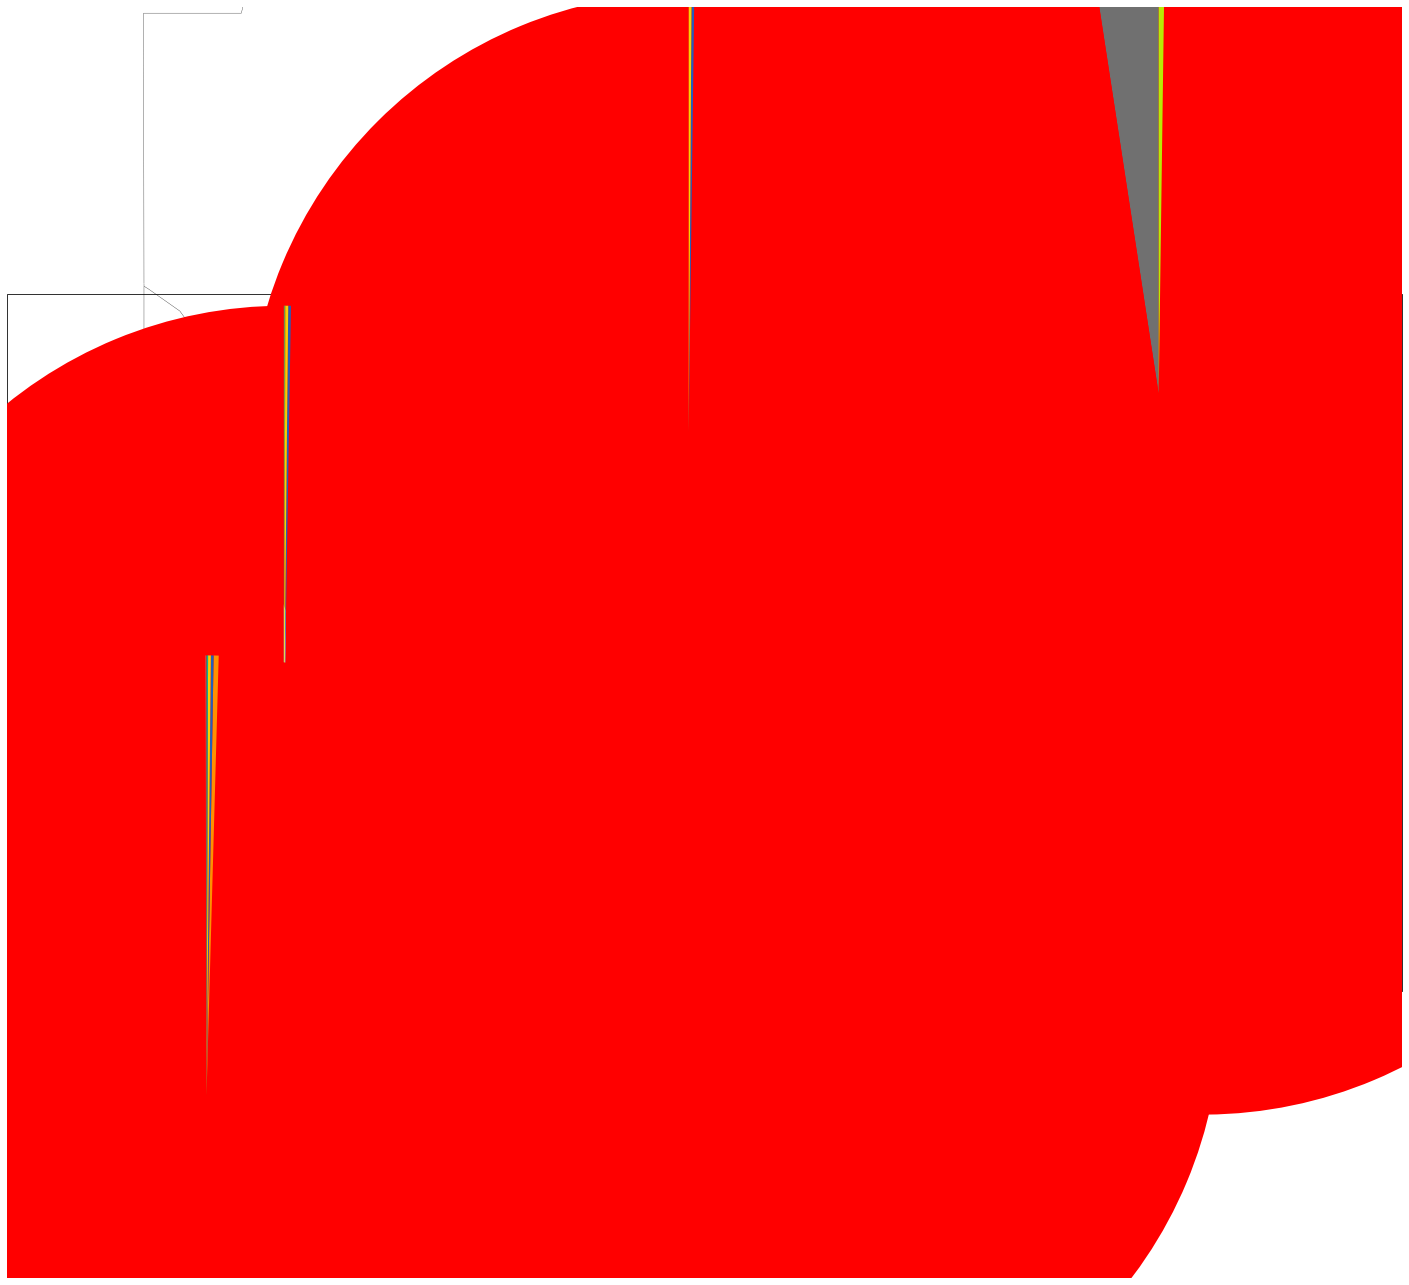

In [27]:
fig, ax = plt.subplots(
    figsize=[25,25], subplot_kw={"projection": ccrs.PlateCarree()}
)
n.generators=n.generators[n.generators.carrier!='load_shedding']
n.plot(
    bus_sizes=bus_sizes / bus_size_factor,
    bus_colors=tech_colors,
    margin=0.2,
    flow="mean",
    line_widths=0.015,
    link_widths=1,
)
plt.show()

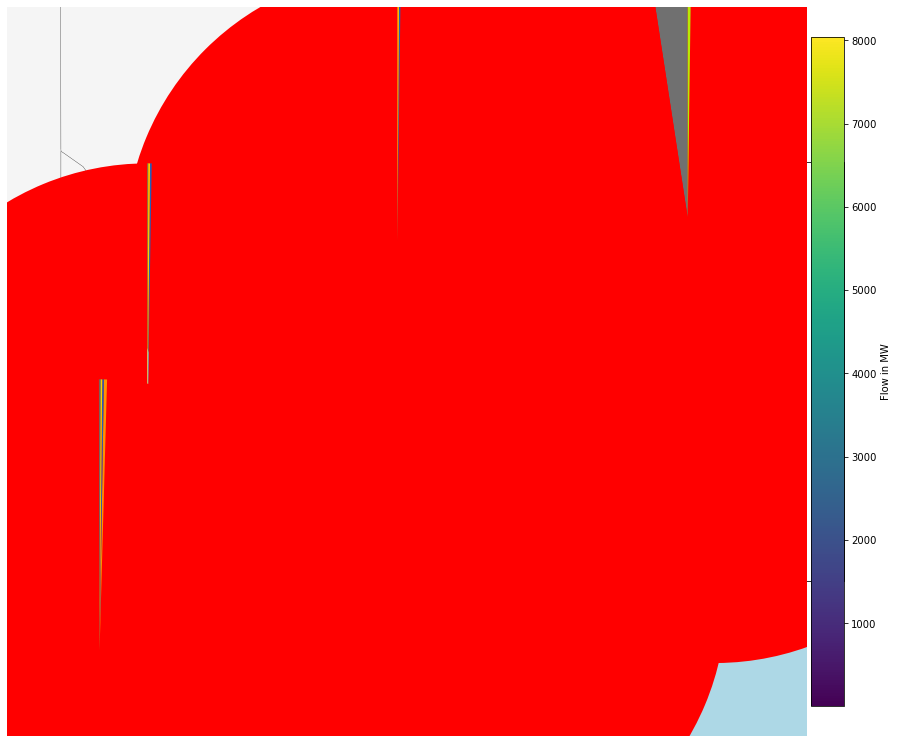

In [22]:
# Pandas series with MultiIndex
# links are not displayed for prettier output ('link_widths=0')
fig, ax = plt.subplots(
    figsize=[15,15], subplot_kw={"projection": ccrs.PlateCarree()}
)

collection = n.plot(
    bus_sizes=bus_sizes / bus_size_factor,
    bus_colors=tech_colors,
    margin=0.15,
    flow=flow,
    line_widths=0.5,
    link_widths=0,
    #projection=ccrs.EqualEarth(),
    color_geomap=True,
    line_colors=n.lines_t.p0.mean().abs(),
)

plt.colorbar(collection[2], fraction=0.04, pad=0.004, label="Flow in MW")
plt.show()

In [28]:
n.generators

,carrier,p_nom,build_year,y,x,efficiency,marginal_cost,capital_cost,ramp_limit_up,lifetime,...,committable,start_up_cost,shut_down_cost,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down
Generator,,,,,,,,,,,,,,,,,,,,,
Duvha,coal,2900.0,2025,-25.95954,29.34094,0.326264,187.211894,5.940000e+05,0.068276,9.0,...,False,0.0,0.0,0,0,1,0,NaN,1.0,1.0
Grootvlei,coal,1080.0,2025,-26.76955,28.49951,0.285488,335.691518,5.940000e+05,0.050000,3.0,...,False,0.0,0.0,0,0,1,0,NaN,1.0,1.0
Hendrina,coal,1900.0,2025,-26.03138,29.60138,0.296760,263.237988,5.940000e+05,0.034737,1.0,...,False,0.0,0.0,0,0,1,0,NaN,1.0,1.0
Kendal,coal,3840.0,2025,-26.08805,28.96888,0.306305,275.616771,5.940000e+05,0.028125,18.0,...,False,0.0,0.0,0,0,1,0,NaN,1.0,1.0
Komati,coal,900.0,2025,-26.09078,29.47446,0.260323,300.400808,5.940000e+05,0.033333,3.0,...,False,0.0,0.0,0,0,1,0,NaN,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
EASTERN CAPE OCGT_2040,OCGT,0.0,2040,NaN,NaN,0.310000,1744.346483,1.170330e+06,NaN,30.0,...,False,0.0,0.0,0,0,1,0,NaN,1.0,1.0
GAUTENG coal_2040,coal,0.0,2040,NaN,NaN,0.370000,344.874383,5.533304e+06,NaN,30.0,...,False,0.0,0.0,0,0,1,0,NaN,1.0,1.0
LIMPOPO coal_2040,coal,0.0,2040,NaN,NaN,0.370000,344.875034,5.533304e+06,NaN,30.0,...,False,0.0,0.0,0,0,1,0,NaN,1.0,1.0
